# 人脸生成（Face Generation）
在该项目中，你将使用生成式对抗网络（Generative Adversarial Nets）来生成新的人脸图像。
### 获取数据
该项目将使用以下数据集：
- MNIST
- CelebA

由于 CelebA 数据集比较复杂，而且这是你第一次使用 GANs。我们想让你先在 MNIST 数据集上测试你的 GANs 模型，以让你更快的评估所建立模型的性能。

如果你在使用 [FloydHub](https://www.floydhub.com/), 请将 `data_dir` 设置为 "/input" 并使用 [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Extracting mnist: 100%|██████████| 60.0K/60.0K [00:11<00:00, 5.10KFile/s]


Extracting celeba...


## 探索数据（Explore the Data）
### MNIST
[MNIST](http://yann.lecun.com/exdb/mnist/) 是一个手写数字的图像数据集。你可以更改 `show_n_images` 探索此数据集。

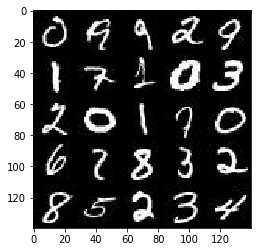

In [1]:
data_dir = './data'
import helper

show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
[CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) 是一个包含 20 多万张名人图片及相关图片说明的数据集。你将用此数据集生成人脸，不会用不到相关说明。你可以更改 `show_n_images` 探索此数据集。

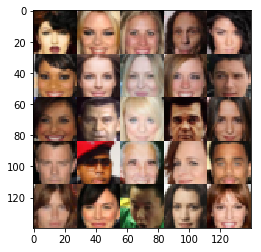

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## 预处理数据（Preprocess the Data）
由于该项目的重点是建立 GANs 模型，我们将为你预处理数据。

经过数据预处理，MNIST 和 CelebA 数据集的值在 28×28 维度图像的 [-0.5, 0.5] 范围内。CelebA 数据集中的图像裁剪了非脸部的图像部分，然后调整到 28x28 维度。

MNIST 数据集中的图像是单[通道](https://en.wikipedia.org/wiki/Channel_(digital_image%29)的黑白图像，CelebA 数据集中的图像是 [三通道的 RGB 彩色图像](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images)。

## 建立神经网络（Build the Neural Network）
你将通过部署以下函数来建立 GANs 的主要组成部分:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### 检查 TensorFlow 版本并获取 GPU 型号
检查你是否使用正确的 TensorFlow 版本，并获取 GPU 型号

In [3]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### 输入（Input）
部署 `model_inputs` 函数以创建用于神经网络的 [占位符 (TF Placeholders)](https://www.tensorflow.org/versions/r0.11/api_docs/python/io_ops/placeholders)。请创建以下占位符：
- 输入图像占位符: 使用 `image_width`，`image_height` 和 `image_channels` 设置为 rank 4。
- 输入 Z 占位符: 设置为 rank 2，并命名为 `z_dim`。
- 学习速率占位符: 设置为 rank 0。

返回占位符元组的形状为 (tensor of real input images, tensor of z data, learning rate)。


In [4]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), 
                                name = "input_real" )
    input_z = tf.placeholder(tf.float32, (None, z_dim), name = "input_z")
    learning_rate = tf.placeholder(tf.float32, (), name = "learning_rate")
    return input_real, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### 辨别器（Discriminator）
部署 `discriminator` 函数创建辨别器神经网络以辨别 `images`。该函数应能够重复使用神经网络中的各种变量。 在 [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) 中使用 "discriminator" 的变量空间名来重复使用该函数中的变量。 

该函数应返回形如 (tensor output of the discriminator, tensor logits of the discriminator) 的元组。

In [5]:
def discriminator(images, reuse=False, alpha = 0.2):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse = reuse):
        # Input layer is 28x28x3
        d_layer1 = tf.layers.conv2d(images, 64, 5, strides = 2, padding = 'same')
        relu1 = tf.maximum(alpha*d_layer1, d_layer1)
        # 14x14x64
        
        d_layer2 = tf.layers.conv2d(relu1, 128, 5, strides = 2, padding = 'same')
        bn2 = tf.layers.batch_normalization(d_layer2, training=True)
        relu2 = tf.maximum(alpha*bn2, bn2)
        # 7x7x128
        
        d_layer3 = tf.layers.conv2d(relu2, 256, 5, strides = 2, padding = 'same')
        bn3 = tf.layers.batch_normalization(d_layer3, training=True)
        relu3 = tf.maximum(alpha*bn3, bn3)
        # 4x4x256               
                
        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### 生成器（Generator）
部署 `generator` 函数以使用 `z` 生成图像。该函数应能够重复使用神经网络中的各种变量。
在 [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) 中使用 "generator" 的变量空间名来重复使用该函数中的变量。 

该函数应返回所生成的 28 x 28 x `out_channel_dim` 维度图像。

In [6]:
def generator(z, out_channel_dim, is_train=True, alpha = 0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse = not is_train):
        x1 = tf.layers.dense(z, 3*3*512)
        x1 = tf.reshape(x1, (-1, 3, 3, 512))
        x1 = tf.layers.batch_normalization(x1, training = is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 3x3x256
         
        x2 = tf.layers.conv2d_transpose(x1, 256, 3, strides = 2, padding = 'valid')
        x2 = tf.layers.batch_normalization(x2, training= is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 7x7x128
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides = 2, padding = 'same')
        x3 = tf.layers.batch_normalization(x3, training= is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # 14x14x64
        
        x4 = tf.layers.conv2d_transpose(x3, 64, 5, strides = 2, padding = 'same')
        x4 = tf.layers.batch_normalization(x4, training= is_train)
        x4 = tf.maximum(alpha * x4, x4)
        # 28x28x64
        
        logits = tf.layers.conv2d_transpose(x4, out_channel_dim, 5, strides=1, padding='same')
        # 28x28x output_dim
        
        out = tf.tanh(logits)       
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### 损失函数（Loss）
部署 `model_loss` 函数训练并计算 GANs 的损失。该函数应返回形如 (discriminator loss, generator loss) 的元组。

使用你已实现的函数：
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [7]:
def model_loss(input_real, input_z, out_channel_dim, smooth=0.1):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_out = generator(input_z, out_channel_dim, is_train=True)
    d_out_real, d_logits_real = discriminator(input_real, reuse=False)
    d_out_fake, d_logits_fake = discriminator(g_out, reuse=True)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_out_real)*(1-smooth)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_out_fake)))
    
    # discriminator loss
    d_loss = d_loss_real + d_loss_fake
    
    # generator loss
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_out_fake)))
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### 优化（Optimization）
部署 `model_opt` 函数实现对 GANs 的优化。使用 [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) 获取可训练的所有变量。通过变量空间名 `discriminator` 和 `generator` 来过滤变量。该函数应返回形如 (discriminator training operation, generator training operation) 的元组。

In [8]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    # the train operations are wrapped in a with tf.control_dependencies block 
    # so the batch normalization layers can update their population statistics.
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## 训练神经网络（Neural Network Training）
### 输出显示
使用该函数可以显示生成器 (Generator) 在训练过程中的当前输出，这会帮你评估 GANs 模型的训练程度。

In [9]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### 训练
部署 `train` 函数以建立并训练 GANs 模型。记得使用以下你已完成的函数：
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

使用 `show_generator_output` 函数显示 `generator` 在训练过程中的输出。

**注意**：在每个批次 (batch) 中运行 `show_generator_output` 函数会显著增加训练时间与该 notebook 的体积。推荐每 100 批次输出一次 `generator` 的输出。 

In [10]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    # Number of color channels
    _, image_w, image_h, n_channels = data_shape
    
    # Model inputs
    input_real, input_z, lr = model_inputs(image_w, image_h, n_channels, z_dim)
    
    # Losses
    d_loss, g_loss = model_loss(input_real, input_z, n_channels)
    
    # Optimizers
    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    # Initial saver
    saver = tf.train.Saver()
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            # Set initial steps and sums
            steps = 0
            d_loss_sum = 0
            g_loss_sum = 0
            batch_count = 0
            
            for batch_images in get_batches(batch_size):
                
                # TODO: Train Model
                steps += 1
                batch_count += 1
                
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                batch_images = batch_images * 2.0
                
                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                
                # Update loss sums
                d_loss_sum += d_loss.eval({input_z: batch_z, input_real: batch_images})
                g_loss_sum += g_loss.eval({input_z: batch_z})
                
                # Print the losses
                if steps%10 == 0:                    
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Avg. Discriminator Loss: {:.4f}...".format(d_loss_sum / batch_count),
                          "Avg. Generator Loss: {:.4f}".format(g_loss_sum / batch_count))
                    
                    # Reset loss sums
                    d_loss_sum = 0
                    g_loss_sum = 0
                    
                    # Reset batch_count
                    batch_count = 0
                
                if steps%100 == 0:                     
                    # Generator output
                    show_generator_output(sess, 16, input_z, n_channels, data_image_mode)    
                    
        saver.save(sess, './checkpoints/gan.ckpt')
                
                

### MNIST
在 MNIST 上测试你的 GANs 模型。经过 2 次迭代，GANs 应该能够生成类似手写数字的图像。确保生成器 (generator) 低于辨别器 (discriminator) 的损失，或接近 0。

Epoch 1/2... Avg. Discriminator Loss: 0.9831... Avg. Generator Loss: 1.6771
Epoch 1/2... Avg. Discriminator Loss: 0.5287... Avg. Generator Loss: 3.3960
Epoch 1/2... Avg. Discriminator Loss: 0.4145... Avg. Generator Loss: 3.3528
Epoch 1/2... Avg. Discriminator Loss: 1.2352... Avg. Generator Loss: 5.9213
Epoch 1/2... Avg. Discriminator Loss: 0.5431... Avg. Generator Loss: 4.1091
Epoch 1/2... Avg. Discriminator Loss: 1.4149... Avg. Generator Loss: 3.3076
Epoch 1/2... Avg. Discriminator Loss: 1.6487... Avg. Generator Loss: 2.4043
Epoch 1/2... Avg. Discriminator Loss: 0.7970... Avg. Generator Loss: 1.9081
Epoch 1/2... Avg. Discriminator Loss: 0.6947... Avg. Generator Loss: 1.9799
Epoch 1/2... Avg. Discriminator Loss: 0.5389... Avg. Generator Loss: 2.4169


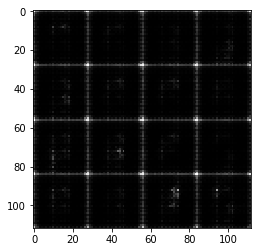

Epoch 1/2... Avg. Discriminator Loss: 0.7455... Avg. Generator Loss: 1.8328
Epoch 1/2... Avg. Discriminator Loss: 0.9210... Avg. Generator Loss: 1.6897
Epoch 1/2... Avg. Discriminator Loss: 0.9862... Avg. Generator Loss: 1.6576
Epoch 1/2... Avg. Discriminator Loss: 0.8772... Avg. Generator Loss: 1.7197
Epoch 1/2... Avg. Discriminator Loss: 0.7923... Avg. Generator Loss: 1.8005
Epoch 1/2... Avg. Discriminator Loss: 0.8948... Avg. Generator Loss: 1.7231
Epoch 1/2... Avg. Discriminator Loss: 0.9842... Avg. Generator Loss: 1.4421
Epoch 1/2... Avg. Discriminator Loss: 0.8909... Avg. Generator Loss: 1.6577
Epoch 1/2... Avg. Discriminator Loss: 1.1665... Avg. Generator Loss: 1.4360
Epoch 1/2... Avg. Discriminator Loss: 0.7955... Avg. Generator Loss: 1.6741


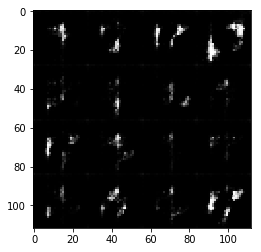

Epoch 1/2... Avg. Discriminator Loss: 0.9306... Avg. Generator Loss: 1.5347
Epoch 1/2... Avg. Discriminator Loss: 0.9781... Avg. Generator Loss: 1.6484
Epoch 1/2... Avg. Discriminator Loss: 0.9111... Avg. Generator Loss: 1.7003
Epoch 1/2... Avg. Discriminator Loss: 1.0503... Avg. Generator Loss: 1.3659
Epoch 1/2... Avg. Discriminator Loss: 0.9447... Avg. Generator Loss: 1.4194
Epoch 1/2... Avg. Discriminator Loss: 1.0488... Avg. Generator Loss: 1.4635
Epoch 1/2... Avg. Discriminator Loss: 0.9402... Avg. Generator Loss: 1.5414
Epoch 1/2... Avg. Discriminator Loss: 1.0751... Avg. Generator Loss: 1.2812
Epoch 1/2... Avg. Discriminator Loss: 1.0453... Avg. Generator Loss: 1.3186
Epoch 1/2... Avg. Discriminator Loss: 1.1816... Avg. Generator Loss: 1.3677


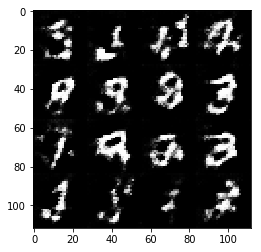

Epoch 1/2... Avg. Discriminator Loss: 1.1040... Avg. Generator Loss: 1.1881
Epoch 1/2... Avg. Discriminator Loss: 1.0423... Avg. Generator Loss: 1.2851
Epoch 1/2... Avg. Discriminator Loss: 1.0813... Avg. Generator Loss: 1.2563
Epoch 1/2... Avg. Discriminator Loss: 1.0750... Avg. Generator Loss: 1.2570
Epoch 1/2... Avg. Discriminator Loss: 1.0442... Avg. Generator Loss: 1.2243
Epoch 1/2... Avg. Discriminator Loss: 0.9868... Avg. Generator Loss: 1.2333
Epoch 1/2... Avg. Discriminator Loss: 1.1078... Avg. Generator Loss: 1.2493
Epoch 1/2... Avg. Discriminator Loss: 1.1137... Avg. Generator Loss: 1.2758
Epoch 1/2... Avg. Discriminator Loss: 0.9892... Avg. Generator Loss: 1.1934
Epoch 1/2... Avg. Discriminator Loss: 1.0038... Avg. Generator Loss: 1.2492


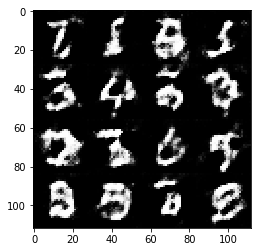

Epoch 1/2... Avg. Discriminator Loss: 1.0711... Avg. Generator Loss: 1.2113
Epoch 1/2... Avg. Discriminator Loss: 1.0196... Avg. Generator Loss: 1.2471
Epoch 1/2... Avg. Discriminator Loss: 1.0958... Avg. Generator Loss: 1.1733
Epoch 1/2... Avg. Discriminator Loss: 1.1106... Avg. Generator Loss: 1.2386
Epoch 1/2... Avg. Discriminator Loss: 1.0260... Avg. Generator Loss: 1.2881
Epoch 1/2... Avg. Discriminator Loss: 1.0403... Avg. Generator Loss: 1.2263
Epoch 1/2... Avg. Discriminator Loss: 1.0750... Avg. Generator Loss: 1.2494
Epoch 1/2... Avg. Discriminator Loss: 0.9788... Avg. Generator Loss: 1.1906
Epoch 1/2... Avg. Discriminator Loss: 1.0624... Avg. Generator Loss: 1.2367
Epoch 1/2... Avg. Discriminator Loss: 1.0689... Avg. Generator Loss: 1.1649


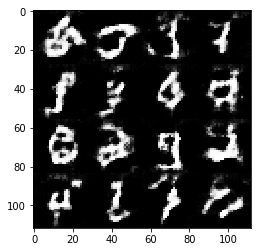

Epoch 1/2... Avg. Discriminator Loss: 1.0030... Avg. Generator Loss: 1.2163
Epoch 1/2... Avg. Discriminator Loss: 1.0881... Avg. Generator Loss: 1.2932
Epoch 1/2... Avg. Discriminator Loss: 1.0479... Avg. Generator Loss: 1.2134
Epoch 1/2... Avg. Discriminator Loss: 1.0439... Avg. Generator Loss: 1.2178
Epoch 1/2... Avg. Discriminator Loss: 1.0584... Avg. Generator Loss: 1.2778
Epoch 1/2... Avg. Discriminator Loss: 1.0446... Avg. Generator Loss: 1.2237
Epoch 1/2... Avg. Discriminator Loss: 1.0638... Avg. Generator Loss: 1.2392
Epoch 1/2... Avg. Discriminator Loss: 1.0607... Avg. Generator Loss: 1.1891
Epoch 1/2... Avg. Discriminator Loss: 1.0943... Avg. Generator Loss: 1.2147
Epoch 1/2... Avg. Discriminator Loss: 1.0227... Avg. Generator Loss: 1.1923


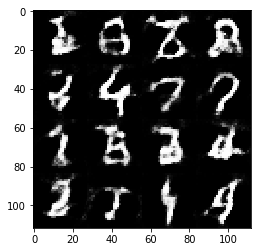

Epoch 1/2... Avg. Discriminator Loss: 0.9903... Avg. Generator Loss: 1.2147
Epoch 1/2... Avg. Discriminator Loss: 1.1123... Avg. Generator Loss: 1.1893
Epoch 1/2... Avg. Discriminator Loss: 1.0328... Avg. Generator Loss: 1.1766
Epoch 1/2... Avg. Discriminator Loss: 0.9966... Avg. Generator Loss: 1.1994
Epoch 1/2... Avg. Discriminator Loss: 1.0611... Avg. Generator Loss: 1.2311
Epoch 1/2... Avg. Discriminator Loss: 0.9979... Avg. Generator Loss: 1.2718
Epoch 1/2... Avg. Discriminator Loss: 1.0245... Avg. Generator Loss: 1.1990
Epoch 1/2... Avg. Discriminator Loss: 1.1250... Avg. Generator Loss: 1.2531
Epoch 1/2... Avg. Discriminator Loss: 1.0452... Avg. Generator Loss: 1.1190
Epoch 1/2... Avg. Discriminator Loss: 0.9791... Avg. Generator Loss: 1.1887


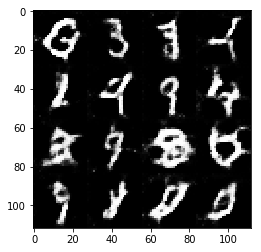

Epoch 1/2... Avg. Discriminator Loss: 1.0291... Avg. Generator Loss: 1.1966
Epoch 1/2... Avg. Discriminator Loss: 1.0248... Avg. Generator Loss: 1.1759
Epoch 1/2... Avg. Discriminator Loss: 1.1084... Avg. Generator Loss: 1.3136
Epoch 1/2... Avg. Discriminator Loss: 1.0445... Avg. Generator Loss: 1.1773
Epoch 1/2... Avg. Discriminator Loss: 1.0370... Avg. Generator Loss: 1.1468
Epoch 1/2... Avg. Discriminator Loss: 1.0272... Avg. Generator Loss: 1.2389
Epoch 1/2... Avg. Discriminator Loss: 1.0914... Avg. Generator Loss: 1.2784
Epoch 1/2... Avg. Discriminator Loss: 1.0229... Avg. Generator Loss: 1.1589
Epoch 1/2... Avg. Discriminator Loss: 1.0765... Avg. Generator Loss: 1.2100
Epoch 1/2... Avg. Discriminator Loss: 1.0273... Avg. Generator Loss: 1.1894


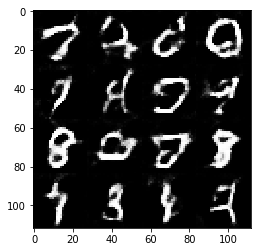

Epoch 1/2... Avg. Discriminator Loss: 1.0461... Avg. Generator Loss: 1.1620
Epoch 1/2... Avg. Discriminator Loss: 1.0718... Avg. Generator Loss: 1.2466
Epoch 1/2... Avg. Discriminator Loss: 1.0959... Avg. Generator Loss: 1.1313
Epoch 1/2... Avg. Discriminator Loss: 1.0688... Avg. Generator Loss: 1.1592
Epoch 1/2... Avg. Discriminator Loss: 1.0576... Avg. Generator Loss: 1.1847
Epoch 1/2... Avg. Discriminator Loss: 1.0691... Avg. Generator Loss: 1.1749
Epoch 1/2... Avg. Discriminator Loss: 1.0025... Avg. Generator Loss: 1.1685
Epoch 1/2... Avg. Discriminator Loss: 1.0135... Avg. Generator Loss: 1.1569
Epoch 1/2... Avg. Discriminator Loss: 1.0853... Avg. Generator Loss: 1.1947
Epoch 1/2... Avg. Discriminator Loss: 1.0076... Avg. Generator Loss: 1.2047


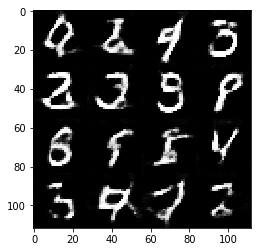

Epoch 1/2... Avg. Discriminator Loss: 1.1098... Avg. Generator Loss: 1.1517
Epoch 1/2... Avg. Discriminator Loss: 1.0219... Avg. Generator Loss: 1.1767
Epoch 1/2... Avg. Discriminator Loss: 1.0001... Avg. Generator Loss: 1.1866
Epoch 2/2... Avg. Discriminator Loss: 1.1376... Avg. Generator Loss: 1.2646
Epoch 2/2... Avg. Discriminator Loss: 0.9970... Avg. Generator Loss: 1.1186
Epoch 2/2... Avg. Discriminator Loss: 1.0072... Avg. Generator Loss: 1.2047
Epoch 2/2... Avg. Discriminator Loss: 0.9307... Avg. Generator Loss: 1.2102
Epoch 2/2... Avg. Discriminator Loss: 1.1533... Avg. Generator Loss: 1.2456
Epoch 2/2... Avg. Discriminator Loss: 1.0804... Avg. Generator Loss: 1.1949
Epoch 2/2... Avg. Discriminator Loss: 1.0172... Avg. Generator Loss: 1.1115
Epoch 2/2... Avg. Discriminator Loss: 1.0846... Avg. Generator Loss: 1.2082
Epoch 2/2... Avg. Discriminator Loss: 1.0205... Avg. Generator Loss: 1.2310
Epoch 2/2... Avg. Discriminator Loss: 1.0022... Avg. Generator Loss: 1.1142


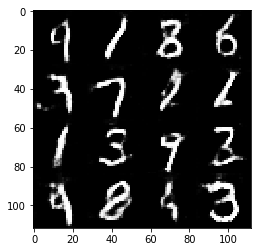

Epoch 2/2... Avg. Discriminator Loss: 1.0182... Avg. Generator Loss: 1.1831
Epoch 2/2... Avg. Discriminator Loss: 1.0823... Avg. Generator Loss: 1.1745
Epoch 2/2... Avg. Discriminator Loss: 1.1179... Avg. Generator Loss: 1.2236
Epoch 2/2... Avg. Discriminator Loss: 0.9866... Avg. Generator Loss: 1.1435
Epoch 2/2... Avg. Discriminator Loss: 0.9500... Avg. Generator Loss: 1.1846
Epoch 2/2... Avg. Discriminator Loss: 1.0199... Avg. Generator Loss: 1.1910
Epoch 2/2... Avg. Discriminator Loss: 0.9898... Avg. Generator Loss: 1.2162
Epoch 2/2... Avg. Discriminator Loss: 1.0350... Avg. Generator Loss: 1.2533
Epoch 2/2... Avg. Discriminator Loss: 1.0612... Avg. Generator Loss: 1.2421
Epoch 2/2... Avg. Discriminator Loss: 0.9857... Avg. Generator Loss: 1.1553


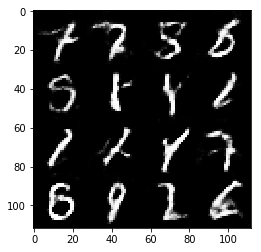

Epoch 2/2... Avg. Discriminator Loss: 0.9861... Avg. Generator Loss: 1.2484
Epoch 2/2... Avg. Discriminator Loss: 1.1274... Avg. Generator Loss: 1.2598
Epoch 2/2... Avg. Discriminator Loss: 0.9624... Avg. Generator Loss: 1.1234
Epoch 2/2... Avg. Discriminator Loss: 1.0847... Avg. Generator Loss: 1.2602
Epoch 2/2... Avg. Discriminator Loss: 0.9741... Avg. Generator Loss: 1.1522
Epoch 2/2... Avg. Discriminator Loss: 1.3218... Avg. Generator Loss: 1.4162
Epoch 2/2... Avg. Discriminator Loss: 1.0030... Avg. Generator Loss: 1.2294
Epoch 2/2... Avg. Discriminator Loss: 0.9449... Avg. Generator Loss: 1.1707
Epoch 2/2... Avg. Discriminator Loss: 0.9280... Avg. Generator Loss: 1.1724
Epoch 2/2... Avg. Discriminator Loss: 1.0507... Avg. Generator Loss: 1.2170


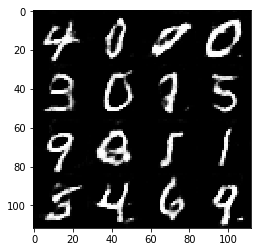

Epoch 2/2... Avg. Discriminator Loss: 1.0295... Avg. Generator Loss: 1.0951
Epoch 2/2... Avg. Discriminator Loss: 0.9380... Avg. Generator Loss: 1.1653
Epoch 2/2... Avg. Discriminator Loss: 0.9394... Avg. Generator Loss: 1.1077


In [ ]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
在 CelebA 上运行你的 GANs 模型。在一般的GPU上运行每次迭代大约需要 20 分钟。你可以运行整个迭代，或者当 GANs 开始产生真实人脸图像时停止它。

Epoch 1/1... Avg. Discriminator Loss: 1.2960... Avg. Generator Loss: 1.2020
Epoch 1/1... Avg. Discriminator Loss: 0.6429... Avg. Generator Loss: 2.2018
Epoch 1/1... Avg. Discriminator Loss: 0.6062... Avg. Generator Loss: 3.6965
Epoch 1/1... Avg. Discriminator Loss: 0.7766... Avg. Generator Loss: 3.3614
Epoch 1/1... Avg. Discriminator Loss: 1.0642... Avg. Generator Loss: 4.8201
Epoch 1/1... Avg. Discriminator Loss: 0.9198... Avg. Generator Loss: 2.4014
Epoch 1/1... Avg. Discriminator Loss: 0.7747... Avg. Generator Loss: 2.0460
Epoch 1/1... Avg. Discriminator Loss: 0.6822... Avg. Generator Loss: 2.2681
Epoch 1/1... Avg. Discriminator Loss: 0.7289... Avg. Generator Loss: 2.4142
Epoch 1/1... Avg. Discriminator Loss: 0.7551... Avg. Generator Loss: 2.4562


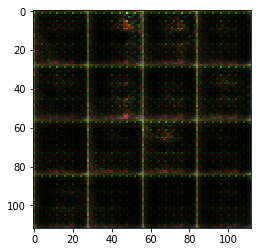

Epoch 1/1... Avg. Discriminator Loss: 0.7588... Avg. Generator Loss: 2.3624
Epoch 1/1... Avg. Discriminator Loss: 0.8390... Avg. Generator Loss: 2.7226
Epoch 1/1... Avg. Discriminator Loss: 0.9019... Avg. Generator Loss: 2.4626
Epoch 1/1... Avg. Discriminator Loss: 0.8434... Avg. Generator Loss: 2.0959
Epoch 1/1... Avg. Discriminator Loss: 1.1318... Avg. Generator Loss: 2.3426
Epoch 1/1... Avg. Discriminator Loss: 0.7544... Avg. Generator Loss: 1.8949
Epoch 1/1... Avg. Discriminator Loss: 0.8429... Avg. Generator Loss: 2.1436
Epoch 1/1... Avg. Discriminator Loss: 1.0489... Avg. Generator Loss: 2.7199
Epoch 1/1... Avg. Discriminator Loss: 1.0615... Avg. Generator Loss: 1.9613
Epoch 1/1... Avg. Discriminator Loss: 0.7146... Avg. Generator Loss: 1.8778


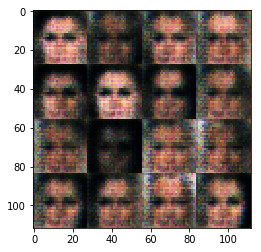

Epoch 1/1... Avg. Discriminator Loss: 0.9969... Avg. Generator Loss: 1.9904
Epoch 1/1... Avg. Discriminator Loss: 0.8644... Avg. Generator Loss: 2.1075
Epoch 1/1... Avg. Discriminator Loss: 0.6387... Avg. Generator Loss: 2.1759
Epoch 1/1... Avg. Discriminator Loss: 0.8821... Avg. Generator Loss: 2.2193
Epoch 1/1... Avg. Discriminator Loss: 0.7195... Avg. Generator Loss: 1.9925
Epoch 1/1... Avg. Discriminator Loss: 0.8619... Avg. Generator Loss: 1.8944
Epoch 1/1... Avg. Discriminator Loss: 0.7389... Avg. Generator Loss: 1.9276
Epoch 1/1... Avg. Discriminator Loss: 0.8452... Avg. Generator Loss: 2.2291
Epoch 1/1... Avg. Discriminator Loss: 0.8726... Avg. Generator Loss: 2.1451
Epoch 1/1... Avg. Discriminator Loss: 0.9492... Avg. Generator Loss: 2.0608


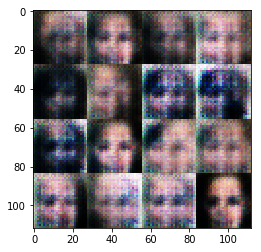

Epoch 1/1... Avg. Discriminator Loss: 0.8539... Avg. Generator Loss: 2.1390
Epoch 1/1... Avg. Discriminator Loss: 1.1025... Avg. Generator Loss: 2.3448
Epoch 1/1... Avg. Discriminator Loss: 0.9991... Avg. Generator Loss: 1.5760
Epoch 1/1... Avg. Discriminator Loss: 0.8750... Avg. Generator Loss: 1.8562
Epoch 1/1... Avg. Discriminator Loss: 0.8279... Avg. Generator Loss: 1.6220
Epoch 1/1... Avg. Discriminator Loss: 1.0346... Avg. Generator Loss: 2.5676
Epoch 1/1... Avg. Discriminator Loss: 0.8905... Avg. Generator Loss: 1.6430
Epoch 1/1... Avg. Discriminator Loss: 0.7781... Avg. Generator Loss: 1.7507
Epoch 1/1... Avg. Discriminator Loss: 0.6919... Avg. Generator Loss: 1.9297
Epoch 1/1... Avg. Discriminator Loss: 0.7752... Avg. Generator Loss: 2.0139


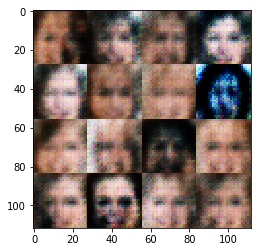

Epoch 1/1... Avg. Discriminator Loss: 0.7070... Avg. Generator Loss: 2.2241
Epoch 1/1... Avg. Discriminator Loss: 0.6731... Avg. Generator Loss: 2.0939
Epoch 1/1... Avg. Discriminator Loss: 0.6614... Avg. Generator Loss: 1.9360
Epoch 1/1... Avg. Discriminator Loss: 0.7642... Avg. Generator Loss: 2.5018
Epoch 1/1... Avg. Discriminator Loss: 0.8232... Avg. Generator Loss: 2.3435
Epoch 1/1... Avg. Discriminator Loss: 0.9500... Avg. Generator Loss: 2.0777
Epoch 1/1... Avg. Discriminator Loss: 0.8173... Avg. Generator Loss: 1.9623
Epoch 1/1... Avg. Discriminator Loss: 0.7197... Avg. Generator Loss: 1.9239
Epoch 1/1... Avg. Discriminator Loss: 0.6624... Avg. Generator Loss: 2.0307
Epoch 1/1... Avg. Discriminator Loss: 0.6244... Avg. Generator Loss: 2.3837


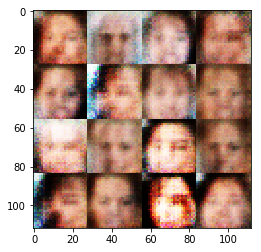

Epoch 1/1... Avg. Discriminator Loss: 0.8521... Avg. Generator Loss: 2.1967
Epoch 1/1... Avg. Discriminator Loss: 0.9823... Avg. Generator Loss: 2.4876
Epoch 1/1... Avg. Discriminator Loss: 1.0059... Avg. Generator Loss: 2.1670
Epoch 1/1... Avg. Discriminator Loss: 0.9513... Avg. Generator Loss: 2.5863
Epoch 1/1... Avg. Discriminator Loss: 0.7747... Avg. Generator Loss: 1.6635
Epoch 1/1... Avg. Discriminator Loss: 0.7594... Avg. Generator Loss: 1.9810
Epoch 1/1... Avg. Discriminator Loss: 1.0995... Avg. Generator Loss: 2.2169
Epoch 1/1... Avg. Discriminator Loss: 0.9759... Avg. Generator Loss: 1.7240
Epoch 1/1... Avg. Discriminator Loss: 0.9816... Avg. Generator Loss: 2.1037
Epoch 1/1... Avg. Discriminator Loss: 0.7432... Avg. Generator Loss: 1.9571


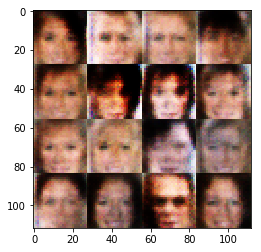

Epoch 1/1... Avg. Discriminator Loss: 0.8144... Avg. Generator Loss: 2.2002
Epoch 1/1... Avg. Discriminator Loss: 0.9789... Avg. Generator Loss: 2.0357
Epoch 1/1... Avg. Discriminator Loss: 0.9941... Avg. Generator Loss: 1.8659
Epoch 1/1... Avg. Discriminator Loss: 0.9052... Avg. Generator Loss: 1.9675
Epoch 1/1... Avg. Discriminator Loss: 0.8068... Avg. Generator Loss: 2.0617
Epoch 1/1... Avg. Discriminator Loss: 0.7235... Avg. Generator Loss: 1.9624
Epoch 1/1... Avg. Discriminator Loss: 1.1574... Avg. Generator Loss: 2.2155
Epoch 1/1... Avg. Discriminator Loss: 0.9623... Avg. Generator Loss: 1.7422
Epoch 1/1... Avg. Discriminator Loss: 0.7581... Avg. Generator Loss: 1.9124
Epoch 1/1... Avg. Discriminator Loss: 0.8917... Avg. Generator Loss: 2.1282


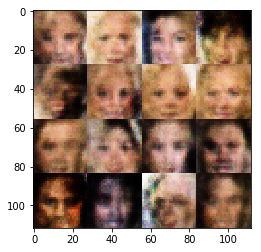

Epoch 1/1... Avg. Discriminator Loss: 0.8738... Avg. Generator Loss: 2.2266
Epoch 1/1... Avg. Discriminator Loss: 0.9303... Avg. Generator Loss: 2.0085
Epoch 1/1... Avg. Discriminator Loss: 0.9994... Avg. Generator Loss: 1.5395
Epoch 1/1... Avg. Discriminator Loss: 0.7420... Avg. Generator Loss: 1.9071
Epoch 1/1... Avg. Discriminator Loss: 1.0128... Avg. Generator Loss: 1.9328
Epoch 1/1... Avg. Discriminator Loss: 1.2348... Avg. Generator Loss: 1.6417
Epoch 1/1... Avg. Discriminator Loss: 0.7270... Avg. Generator Loss: 1.9751
Epoch 1/1... Avg. Discriminator Loss: 0.7571... Avg. Generator Loss: 1.9161
Epoch 1/1... Avg. Discriminator Loss: 1.0590... Avg. Generator Loss: 1.7784
Epoch 1/1... Avg. Discriminator Loss: 0.8987... Avg. Generator Loss: 1.9294


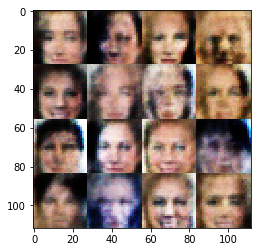

Epoch 1/1... Avg. Discriminator Loss: 0.7084... Avg. Generator Loss: 1.8773
Epoch 1/1... Avg. Discriminator Loss: 1.1744... Avg. Generator Loss: 2.1934
Epoch 1/1... Avg. Discriminator Loss: 0.8749... Avg. Generator Loss: 1.7882
Epoch 1/1... Avg. Discriminator Loss: 0.7579... Avg. Generator Loss: 1.7774
Epoch 1/1... Avg. Discriminator Loss: 0.6940... Avg. Generator Loss: 2.0918
Epoch 1/1... Avg. Discriminator Loss: 1.1025... Avg. Generator Loss: 2.1414
Epoch 1/1... Avg. Discriminator Loss: 0.8843... Avg. Generator Loss: 1.9011
Epoch 1/1... Avg. Discriminator Loss: 0.7137... Avg. Generator Loss: 1.8338
Epoch 1/1... Avg. Discriminator Loss: 0.9616... Avg. Generator Loss: 2.1367
Epoch 1/1... Avg. Discriminator Loss: 1.1898... Avg. Generator Loss: 1.8357


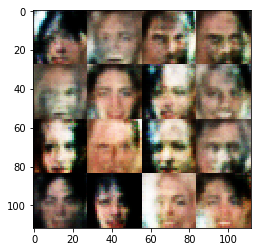

Epoch 1/1... Avg. Discriminator Loss: 0.9705... Avg. Generator Loss: 1.5132
Epoch 1/1... Avg. Discriminator Loss: 0.8691... Avg. Generator Loss: 1.7354
Epoch 1/1... Avg. Discriminator Loss: 0.8650... Avg. Generator Loss: 1.8230
Epoch 1/1... Avg. Discriminator Loss: 0.6740... Avg. Generator Loss: 1.9244
Epoch 1/1... Avg. Discriminator Loss: 0.7046... Avg. Generator Loss: 1.9338
Epoch 1/1... Avg. Discriminator Loss: 1.2303... Avg. Generator Loss: 1.6746
Epoch 1/1... Avg. Discriminator Loss: 0.8472... Avg. Generator Loss: 1.8676
Epoch 1/1... Avg. Discriminator Loss: 0.8647... Avg. Generator Loss: 1.7955
Epoch 1/1... Avg. Discriminator Loss: 1.0013... Avg. Generator Loss: 1.7060
Epoch 1/1... Avg. Discriminator Loss: 0.7140... Avg. Generator Loss: 1.9416


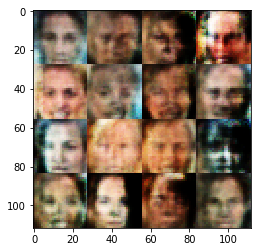

Epoch 1/1... Avg. Discriminator Loss: 0.7716... Avg. Generator Loss: 2.1925
Epoch 1/1... Avg. Discriminator Loss: 1.1308... Avg. Generator Loss: 1.4012
Epoch 1/1... Avg. Discriminator Loss: 0.7821... Avg. Generator Loss: 1.7107
Epoch 1/1... Avg. Discriminator Loss: 0.6780... Avg. Generator Loss: 1.8511
Epoch 1/1... Avg. Discriminator Loss: 0.9872... Avg. Generator Loss: 1.9214
Epoch 1/1... Avg. Discriminator Loss: 1.1811... Avg. Generator Loss: 1.6733
Epoch 1/1... Avg. Discriminator Loss: 0.8442... Avg. Generator Loss: 1.5583
Epoch 1/1... Avg. Discriminator Loss: 0.7183... Avg. Generator Loss: 1.8356
Epoch 1/1... Avg. Discriminator Loss: 0.7369... Avg. Generator Loss: 1.8364
Epoch 1/1... Avg. Discriminator Loss: 0.6909... Avg. Generator Loss: 1.9594


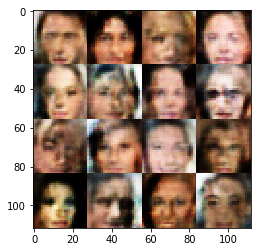

Epoch 1/1... Avg. Discriminator Loss: 0.9348... Avg. Generator Loss: 1.8161
Epoch 1/1... Avg. Discriminator Loss: 0.8510... Avg. Generator Loss: 1.7998
Epoch 1/1... Avg. Discriminator Loss: 0.7627... Avg. Generator Loss: 2.0517
Epoch 1/1... Avg. Discriminator Loss: 0.7384... Avg. Generator Loss: 1.8277
Epoch 1/1... Avg. Discriminator Loss: 1.1712... Avg. Generator Loss: 1.8669
Epoch 1/1... Avg. Discriminator Loss: 1.0759... Avg. Generator Loss: 1.6036
Epoch 1/1... Avg. Discriminator Loss: 0.7720... Avg. Generator Loss: 1.6925
Epoch 1/1... Avg. Discriminator Loss: 0.7313... Avg. Generator Loss: 1.9457
Epoch 1/1... Avg. Discriminator Loss: 0.9560... Avg. Generator Loss: 1.7959
Epoch 1/1... Avg. Discriminator Loss: 0.9046... Avg. Generator Loss: 1.7705


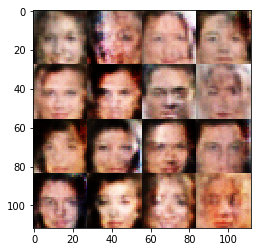

Epoch 1/1... Avg. Discriminator Loss: 0.8436... Avg. Generator Loss: 1.8065
Epoch 1/1... Avg. Discriminator Loss: 1.2622... Avg. Generator Loss: 1.4456
Epoch 1/1... Avg. Discriminator Loss: 0.8886... Avg. Generator Loss: 1.6708
Epoch 1/1... Avg. Discriminator Loss: 1.1326... Avg. Generator Loss: 1.5155
Epoch 1/1... Avg. Discriminator Loss: 0.7500... Avg. Generator Loss: 1.7939
Epoch 1/1... Avg. Discriminator Loss: 0.7440... Avg. Generator Loss: 1.6445
Epoch 1/1... Avg. Discriminator Loss: 0.9845... Avg. Generator Loss: 1.5683
Epoch 1/1... Avg. Discriminator Loss: 0.9465... Avg. Generator Loss: 1.7298
Epoch 1/1... Avg. Discriminator Loss: 0.7409... Avg. Generator Loss: 1.7894
Epoch 1/1... Avg. Discriminator Loss: 0.7741... Avg. Generator Loss: 1.8416


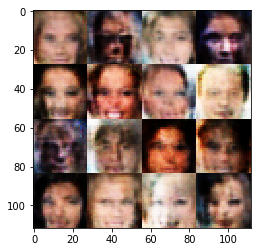

Epoch 1/1... Avg. Discriminator Loss: 0.7956... Avg. Generator Loss: 1.7195
Epoch 1/1... Avg. Discriminator Loss: 0.9682... Avg. Generator Loss: 1.5488
Epoch 1/1... Avg. Discriminator Loss: 0.7971... Avg. Generator Loss: 1.5214
Epoch 1/1... Avg. Discriminator Loss: 0.9673... Avg. Generator Loss: 1.5486
Epoch 1/1... Avg. Discriminator Loss: 0.8332... Avg. Generator Loss: 1.6900
Epoch 1/1... Avg. Discriminator Loss: 0.7600... Avg. Generator Loss: 1.7436
Epoch 1/1... Avg. Discriminator Loss: 1.1134... Avg. Generator Loss: 1.9198


In [ ]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### 提交项目
提交本项目前，确保运行所有 cells 后保存该文件。

保存该文件为 "dlnd_face_generation.ipynb"， 并另存为 HTML 格式 "File" -> "Download as"。提交项目时请附带 "helper.py" 和 "problem_unittests.py" 文件。